In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, OneHotEncoder, StandardScaler
from scipy.stats import randint
import string
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, \
    mean_squared_log_error, r2_score

In [2]:
def evaluate_classifier(model, x_test, y_test, title):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("")
    print(f"{title.title()}:")
    print(f"Accuracy:           {accuracy}")
    print(f"F1 score:           {f1}")
    print("Confusion Matrix:")

    disp = ConfusionMatrixDisplay.from_estimator(model, x_test, y_test,
                                                 cmap=plt.cm.Blues, normalize='true')
    disp.ax_.set_title(title)
    plt.show()

def evaluate_regressor(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = np.abs(y_pred)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    msle = mean_squared_log_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("")
    print("Test set results:")
    print(" - MAE:", mae)
    print(" - MSE:", mse)
    print(" - MSLE:", msle)
    print(" - R2:", r2)
    print("")
    print("Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.")

def get_categorical_features(df):
    return df.select_dtypes(include=['object']).columns

def get_k_correlated(dataset, y_name, k=5):
    y_corr = dataset.corr()[y_name].abs().sort_values(ascending=False)
    return y_corr[1:(k+1)].index.tolist()

def clean_text(text):
    text = text.lower()
    text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

In [3]:
dataset = pd.read_csv('./data/dataset.csv')
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
dataset = dataset.drop(columns='customerID')

In [6]:
dataset = dataset.dropna(how='any')

In [7]:
for feature in dataset.columns:
    print(f'{feature}: {dataset[feature].unique()}')

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalChar

In [8]:
dataset['gender'] = dataset['gender'].map({'Male' : 0, 'Female' : 1})
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,0,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,0,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,0,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,1,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
dataset['Churn'] = dataset['Churn'].map({'Yes' : 1, 'No' : 0})
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,0,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,0,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,0,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,1,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [10]:
bin_features = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for bin_feature in bin_features:
    dataset[bin_feature] = dataset[bin_feature].map({'Yes' : 1, 'No' : 0})

bin_features = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for bin_feature in bin_features:
    dataset[bin_feature] = dataset[bin_feature].map({'Yes' : 1, 'No' : 0, 'No internet service' : 0, 'No phone service' : 0})
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.5,0
2,0,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,1,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [11]:
cat_features = ['InternetService', 'Contract', 'PaymentMethod']
for cat_feature in cat_features:
    dataset = pd.concat([dataset, pd.get_dummies(dataset[cat_feature])], axis=1).drop(columns=cat_feature)
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,DSL,Fiber optic,No,Month-to-month,One year,Two year,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,True,False,False,True,False,False,False,False,True,False
1,0,0,0,0,34,1,0,1,0,1,...,True,False,False,False,True,False,False,False,False,True
2,0,0,0,0,2,1,0,1,1,0,...,True,False,False,True,False,False,False,False,False,True
3,0,0,0,0,45,0,0,1,0,1,...,True,False,False,False,True,False,True,False,False,False
4,1,0,0,0,2,1,0,0,0,0,...,False,True,False,True,False,False,False,False,True,False


In [12]:
dataset.loc[dataset['TotalCharges'] == ' ', 'TotalCharges'] = '0.0'

In [13]:
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns='Churn'), dataset['Churn'], test_size=0.25)

In [14]:
lr = LogisticRegression(max_iter=1000000)
rf = RandomForestClassifier(n_estimators=20, criterion='gini')
dc = DummyClassifier()

lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)

rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)

dc.fit(x_train, y_train)
dc_pred = dc.predict(x_test)


Logistic Regression:
Accuracy:           0.8052243043725156
F1 score:           0.6106696935300795
Confusion Matrix:


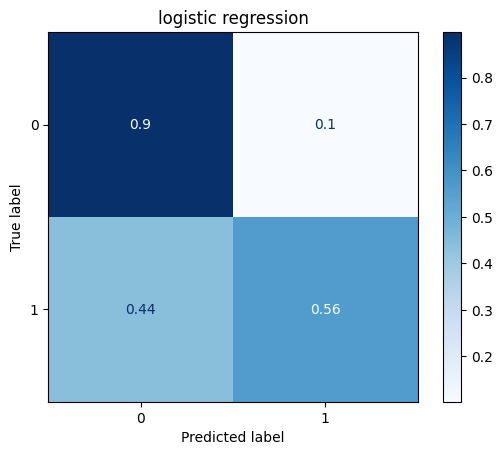


Random Forest:
Accuracy:           0.7802385008517888
F1 score:           0.5216316440049443
Confusion Matrix:


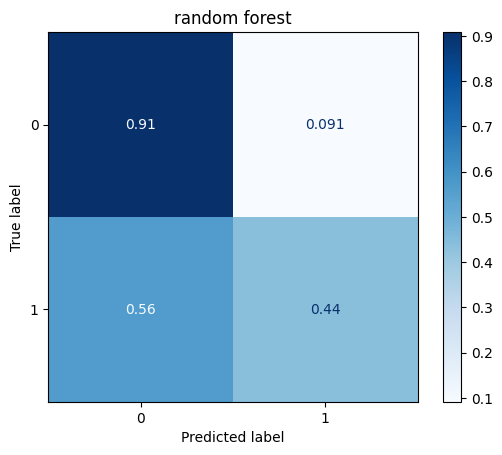


Dummy Classifier:
Accuracy:           0.7268597387847814
F1 score:           0.0
Confusion Matrix:


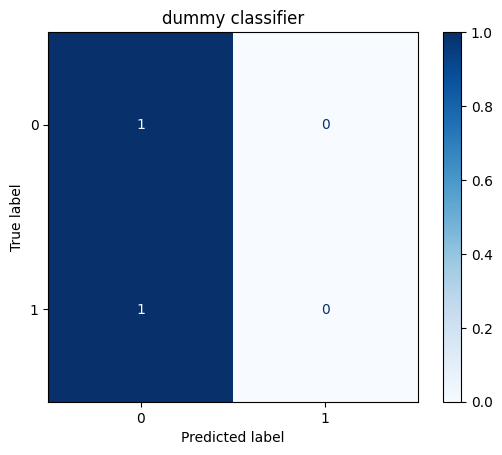

In [15]:
evaluate_classifier(lr, x_test, y_test, 'logistic regression')
evaluate_classifier(rf, x_test, y_test, 'random forest')
evaluate_classifier(dc, x_test, y_test, 'dummy classifier')

In [16]:
test = pd.concat([x_test, y_test], axis=1)
test.groupby('gender')['Churn'].count() / test.shape[0]

gender
0    0.513345
1    0.486655
Name: Churn, dtype: float64

In [17]:
men = test['gender'] == 0

men_pred = rf.predict(x_test[men])
women_pred = rf.predict(x_test[~men])

print(f'Men: {accuracy_score(y_test[men], men_pred)}')
print(f'Women: {accuracy_score(y_test[~men], women_pred)}')

Men: 0.7798672566371682
Women: 0.780630105017503


In [18]:
rf = RandomForestClassifier()
rf.fit(x_train.drop(columns='gender'), y_train)
y_pred = rf.predict(x_test.drop(columns='gender'))
accuracy_score(y_test, y_pred)

0.7808063600227144

In [19]:
men = test['gender'] == 0

men_pred = rf.predict(x_test[men].drop(columns='gender'))
women_pred = rf.predict(x_test[~men].drop(columns='gender'))

print(f'Men: {accuracy_score(y_test[men], men_pred)}')
print(f'Women: {accuracy_score(y_test[~men], women_pred)}')

Men: 0.7842920353982301
Women: 0.7771295215869312


In [20]:
rf = RandomForestClassifier()
distributions = dict(n_estimators=randint(low=5, high=100), max_depth=randint(low=2, high=100))
rscv = RandomizedSearchCV(rf, distributions, random_state=0, n_iter=30, n_jobs=-1)

search = rscv.fit(x_train, y_train)
rf = RandomForestClassifier(n_estimators=search.best_params_['n_estimators'], max_depth=search.best_params_['max_depth'])
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
f1_score(y_test, y_pred), search.best_params_

(0.59465737514518, {'max_depth': 11, 'n_estimators': 62})

In [21]:
df = pd.read_csv('./data/dataset.csv')
cat_features = get_categorical_features(df)
for cat_feature in cat_features:
    df[cat_feature] = LabelEncoder().fit_transform(df[cat_feature])
df = df.drop(columns='customerID')
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,2505,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1466,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,157,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1400,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,925,1



Random Forest - Most Correlated:
Accuracy:           0.7995457126632595
F1 score:           0.5593008739076155
Confusion Matrix:


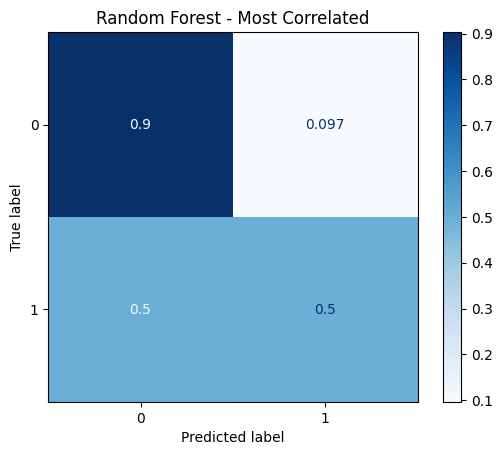

In [22]:
most_corr = get_k_correlated(df, 'Churn')

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='Churn'), df['Churn'], test_size=0.25)
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

evaluate_classifier(rf, x_test, y_test, "Random Forest - Most Correlated")

In [23]:
df = pd.read_csv('./data/dataset.csv')
df = df.drop(columns='customerID')
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
X, Y = df.drop(columns='Churn'), df['Churn']
cat_features = get_categorical_features(X)

preprocessing_transformer = ColumnTransformer([
    ('MonthlyCharges_discretized', KBinsDiscretizer(quantile_method='averaged_inverted_cdf'), ['MonthlyCharges']),
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('scale', StandardScaler(), ['SeniorCitizen', 'tenure'])
], remainder='passthrough')

In [24]:
pipeline = Pipeline(steps=[
    ('preprocessing_transformer', preprocessing_transformer),
    ('model', RandomForestClassifier(max_depth=search.best_params_['max_depth'], n_estimators=search.best_params_['n_estimators']))
])


Pipeline:
Accuracy:           0.7586598523566156
F1 score:           0.23423423423423423
Confusion Matrix:


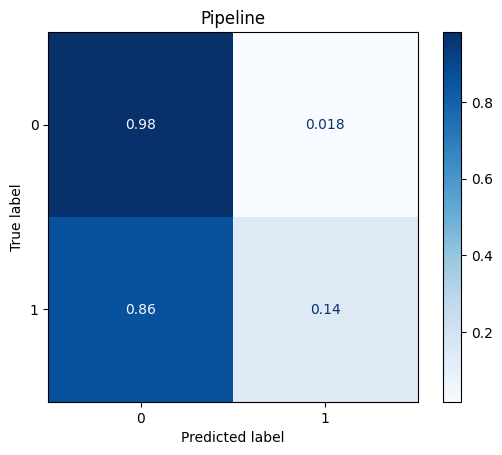

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

pipeline.fit(x_train, y_train)

evaluate_classifier(pipeline, x_test, y_test, 'Pipeline')

In [26]:
pipeline = Pipeline(steps=[
    ('preprocessing_transformer', preprocessing_transformer),
    ('feature_selector', SelectKBest()),
    ('model', RandomForestClassifier(max_depth=search.best_params_['max_depth'], n_estimators=search.best_params_['n_estimators']))
])

parameters = {
    'feature_selector__k' : [10, 15, 20],
    'model__max_depth' : [50, 60, 70],
    'model__n_estimators' : [50, 60, 70]
}

gs = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1)

gs.fit(x_train, y_train)
gs.best_params_

{'feature_selector__k': 10, 'model__max_depth': 50, 'model__n_estimators': 60}